In [1]:
from utils.analyse_runs import *

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype=torch.float64

In [2]:
df = build_runs_df("./runs").sort_values("best_avg_loss")
df

,base_name,timestamp,device_tag,run_folder,kernel_spec,T,batch_size,d,lr,lr_factor,...,final_loss,n_epochs_ran,lr_drops_used,run_path,dtype,device,min_lr,lead_lag,lags,epoch_last
1,esn_vs_ar2,20260213_164815,cpu,esn_vs_ar2_20260213_164815_cpu,"{'kernel_mode': 'static', 'kernel_name': 'RBFK...",200,20,1,0.001,0.5,...,0.006031,959,3,runs/esn_vs_ar2_20260213_164815_cpu,torch.float64,cpu,0.000001,False,1,958
2,esn_vs_ar2,20260213_152409,cpu,esn_vs_ar2_20260213_152409_cpu,"{'kernel_mode': 'static', 'kernel_name': 'RBFK...",200,20,1,0.001,0.5,...,0.005166,840,3,runs/esn_vs_ar2_20260213_152409_cpu,torch.float64,cpu,0.000001,False,1,839
0,esn_vs_ar2,20260213_151448,cpu,esn_vs_ar2_20260213_151448_cpu,"{'kernel_mode': 'static', 'kernel_name': 'RBFK...",200,20,1,0.001,0.5,...,-0.000590,300,2,runs/esn_vs_ar2_20260213_151448_cpu,torch.float64,cpu,0.000001,False,1,299
3,esn_vs_ar2,20260213_171716,cpu,esn_vs_ar2_20260213_171716_cpu,"{'kernel_mode': 'sequential', 'kernel_name': '...",200,20,1,0.001,0.5,...,0.048662,308,3,runs/esn_vs_ar2_20260213_171716_cpu,torch.float64,cpu,0.000001,False,1,307


In [9]:
row = 0  # best run
esn = load_esn_from_df(df, row=row, which="best", map_location=device, dtype=torch.float64)
with torch.no_grad():
    Z = esn(T=200, N=50)
print(Z.shape)

torch.Size([50, 200, 1])


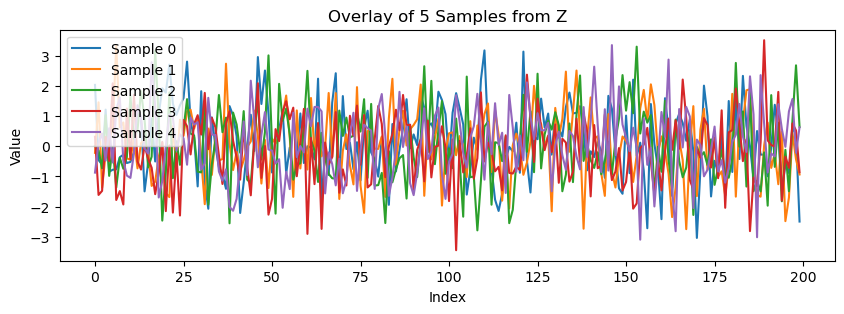

In [10]:
import matplotlib.pyplot as plt

num_samples = 5  # Change this to select how many samples to plot

plt.figure(figsize=(10, 3))
for i in range(num_samples):
    plt.plot(Z[i].cpu().numpy(), label=f'Sample {i}')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title(f'Overlay of {num_samples} Samples from Z')
plt.legend()
plt.show()
